# Extracting Roads From Satellite Images
> * 🔬 Data Science
* 🥠 Deep Learning and pixel-based classification

## Table of Contents
* [Introduction](#Introduction)
* [Export Training Data](#Export-Training-Data)
 * [Export training data](#Export-training-data)
* [Train the Model](#Train-the-Model)
 * [Required Imports](#Required-Imports)
 * [Prepare Data](#Prepare-Data)
 * [Visualise few samples from your Training data](#Visualise-few-samples-from-your-Training-data)
 * [Load an MultiTaskRoadExtractor model](#Load-an-UnetClassifier-model)
 * [Find an Optimal Learning Rate](#Find-an-Optimal-Learning-Rate)
 * [Fit the model](#Fit-the-model)
 * [Save the model](#Save-the-model)
 * [Load an Intermediate model to train it further](#Load-an-Intermediate-model-to-train-it-further)
 * [Preview Results](#Preview-Results)
* [Deploy Model and Extract Roads](#Deploy-Model-and-Extract-Footprints)
 * [Generate a Classified Raster using Classify Pixels Using Deep Learning tool](#Generate-a-Classified-Raster-using-Classify-Pixels-Using-Deep-Learning-tool)
 * [Final Output](#Final-Output)
* [Limitations](#Limitations)


## Introduction

Road Network is a required layer in lot of mapping exercises, for example in basemap preparation, humantitarian aid and disaster management, transportation and a lot of other applications it is a critical component.

This sample shows how ArcGIS API for Python can be used to train a deep learning model to extract road network from satellite imagery. The models trained can be used with ArcGIS Pro or ArcGIS Enterprise and even support distributed processing for quick results.

> For this sample we will be using data which originates from USAA and covers the region affected by Woolsey fires. The Imagery used here is an orthomosaic of data acquired just after the fires using an optical sensor on drone with a spatial resolution of 30cm.


<center>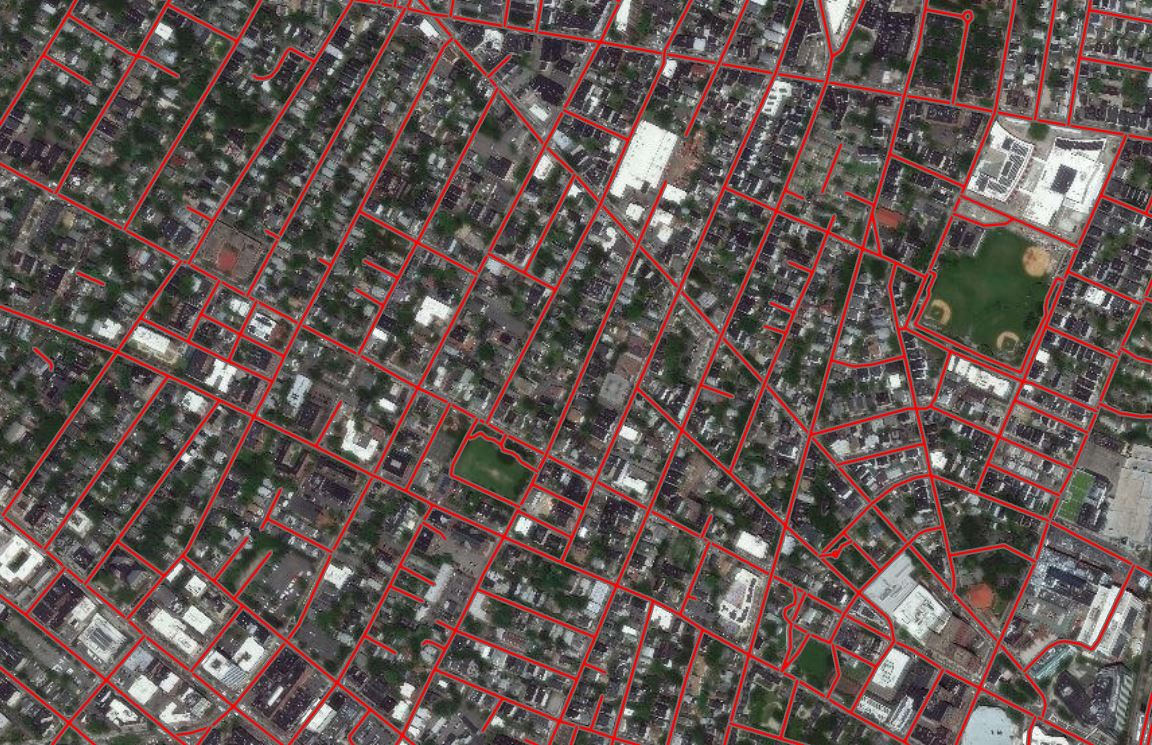</center>

<center>A subset of Satellite Imagery overlayed with Training Data (Road Layer).</center>

In this workflow we will basically have three steps.
* Export Training Data
* Train a Model
* Deploy Model and Extract Roads

## Export Training Data

Training data can be exported by using the 'Export Training Data For Deep Learning' tool available in [ArcGIS Pro](#"https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm") as well as [ArcGIS Enterprise](#"https://developers.arcgis.com/rest/services-reference/export-training-data-for-deep-learning.htm"). For this example we prepared training data in 'Classified Tiles' format using a 'chip_size' of 400px and 'cell_size' of 30cm in ArcGIS Pro. 



Export training data using 'Export Training data for deep learning' tool, [detailed documentation here](#https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm)
- Set satellite imagery as 'Input Raster'.
- Set a location where you want to export the training data, it can be an existing folder or the tool will create that for you.
- Set classified raster as 'Input Feature Class Or Classified Raster'.
- In the option 'Input Mask Polygons' we can set a mask layer to limit the tool to export training data for only those areas which have buildings in it, we created one by generating a grid of 200m by 200m on building footprint layer's extent and dissolving only those polygons which contained buildings to a single multipolygon feature.
- 'Tile Size X' & 'Tile Size Y' can be set 
- Select 'Classified Tiles' as the 'Meta Data Format' because we are training an 'Unet Model'.
- In 'Environments' tab set an optimum 'Cell Size' which is small enough to allow model to learn the texture of building roofs by the details and big enough to allow multiple buildings to fall in one tile and model can also understand the surrounding context of the buildings. For this example we used 0.3 cell size which meant 30cm on a project coordinate system. 

<table>
    <tr>
        <td>
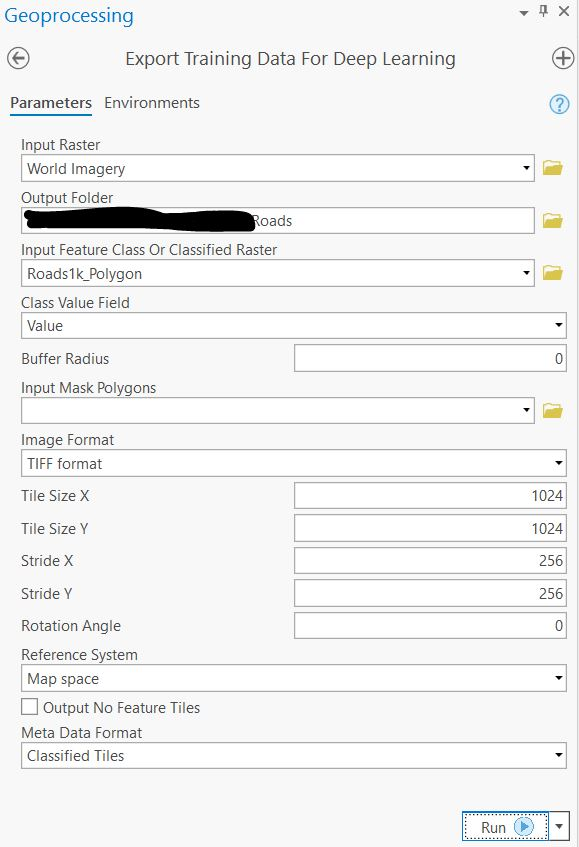
        </td>
        <td>
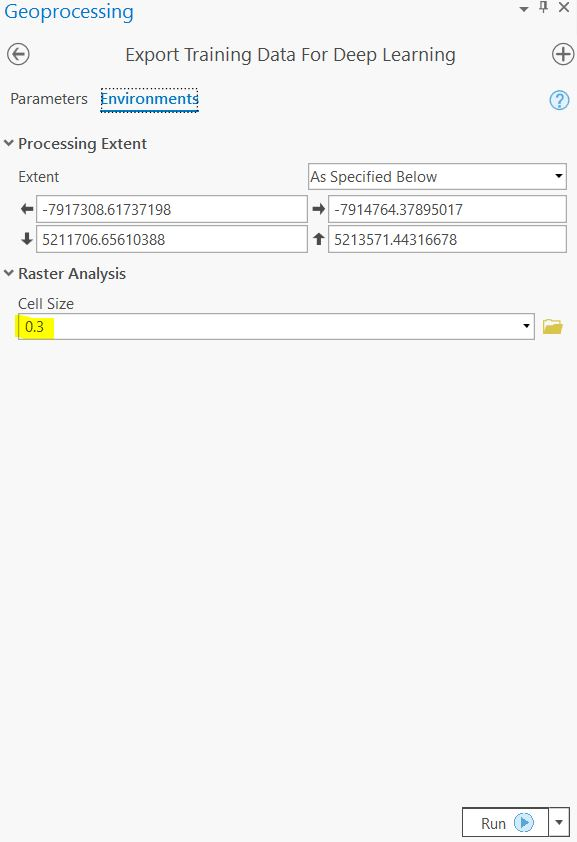
        </td>
    </tr>
</table>
    

This will create all the necessary files needed for the next step in the 'Output Folder', and we will now call it our training data.

## Train the Model

This step would be done using jupyter notebook and documentation is available <a href="https://developers.arcgis.com/python/guide/install-and-set-up/"> here to install and setup environment</a>. 

### Required Imports


In [8]:
import arcgis
from arcgis.learn._factory_data import prepare_data_future

### Prepare Data

We would specify the path to our training data and a few hyper parameters.

`path`: path of folder containing training data.<br/>
`chip_size`: randomly crop the image of chip size from data.<br/>
`batch_size`: No of images your model will train on each step inside an epoch, it directly depends on the memory of your graphic card. 8 worked for us on a 11GB GPU.
`resize_to`: Resize the croped image to mentioned size.<br/>
`road_extractor_params`: define the special parameters for creating Orientation and Road labels for joint training.<br/>
&nbsp;&nbsp;&nbsp;&nbsp;|---> `gaussian_thresh`: set the gaussian threshold which allows to set the required road width.<br/>
&nbsp;&nbsp;&nbsp;&nbsp;|---> `orient_bin_size`: set the bin size for orientation angles.<br/>
&nbsp;&nbsp;&nbsp;&nbsp;|---> `orient_theta`: set the width of orientation mask.<br/>
&nbsp;&nbsp;&nbsp;&nbsp;|---> `is_gaussian_mask`: flag to set, if given labels are converted to gaussian. if false, system will create the gaussian mask internally and convert to &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; binary mask of appropriate road width based on the `gaussian_thresh`<br/>
`sub_dataset_type`: special sub dataset type required for creating the Orientation data. <br/>

#### Creating Gaussian Road Mask

We will create gaussian mask using the following python code and it will help to train the model faster. 

In [2]:
import os
import glob
from pathlib import Path

data_path = r'C:\Users\Anil\Downloads\Boston_Roads2'
gauss_path = str(Path(data_path + '/gauss_labels'))

if not os.path.exists(gauss_path):
    os.makedirs(gauss_path)

labels = []
for file_ in glob.glob(str(Path(data_path + '/labels/*.tif'))):
    labels.append(file_)

In [3]:
import numpy as np
from PIL import Image
from pathlib import Path
from multiprocessing import Pool
from tqdm.notebook import tqdm
from skimage.morphology import skeletonize
from scipy.ndimage.morphology import distance_transform_edt

def _createGaussianMask(gt_array):
    """
    Create Gaussian road mask for given road label.
        1 - Perform Skeletonization
        2 - Compute Distance Transform
        3 - Convert Gaussian Road Mask using standard Deviation of 15
    """
    gt_array = skeletonize(gt_array)
    distance_array = distance_transform_edt(1 - (gt_array))
    std = 15
    distance_array = np.exp(-0.5 * (distance_array * distance_array) / (std * std))

    return distance_array

def save_one_image(file_path):
    name = Path(file_path).stem
    label = Image.open(file_path)
    gauss_label = _createGaussianMask(np.asarray(label).astype(np.float32))
    gauss_label = Image.fromarray((gauss_label*255.0).astype(np.uint8))
    gauss_label.save(gauss_path + "/{}.{}".format(name, "tif"))

if sys.platform == "win32":
    for i, label in tqdm(enumerate(labels), total=len(labels)):
        save_one_image(label)
else:
    with Pool(processes=50) as p:
        with tqdm(total=len(labels)) as pbar:
            for i, _ in enumerate(p.imap_unordered(save_one_image, labels)):
                pbar.update()

###### Note: Rename the `gauss_labels` folder to `labels` and provide any name to existing `labels` folder generated while exporting the data.

#### Creating ArcGIS Data

In [13]:
# Prepare Data
data_path = r'C:\Users\Anil\Downloads\Boston_Roads2'
data = prepare_data_future(
    data_path, chip_size=768, transforms=None, 
    batch_size=2, val_split_pct=0.3, resize_to=512,
    road_extractor_params={"gaussian_thresh":0.75, "orient_bin_size":10, "orient_theta": 15.0, "is_gaussian_mask": True},
    sub_dataset_type="RoadOrientation",
)

Fetching Data Object using Factory Pattern.


### Visualise a few samples from your Training data
The code below shows a few samples of our data with the same symbology as in ArcGIS Pro.

`rows`: No of rows we want to see the results for.

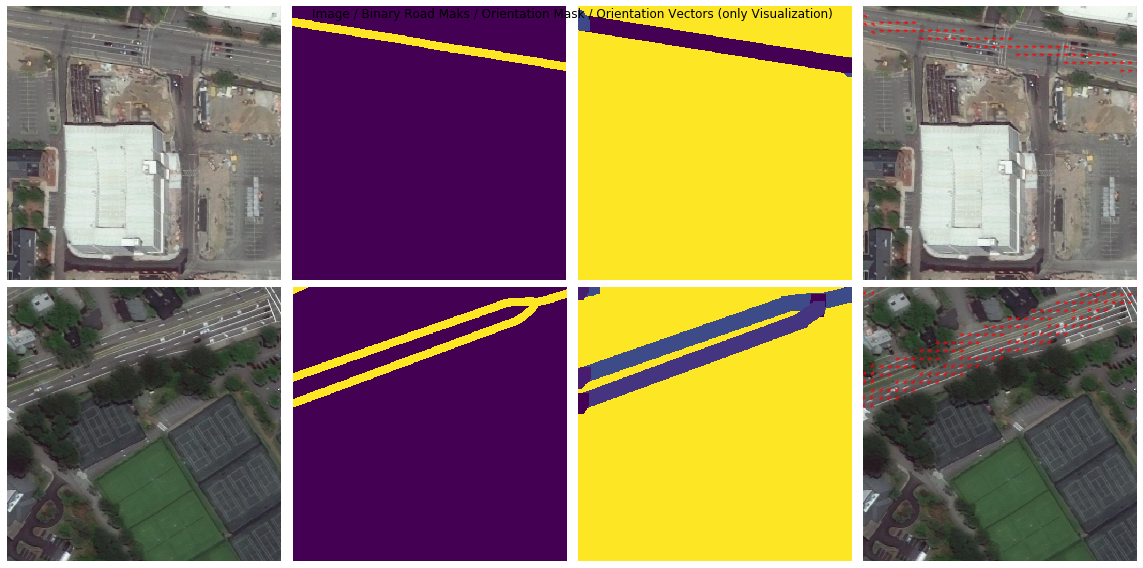

In [14]:
data.show_batch(rows=2)

### Load an `MultiTaskRoadExtractor` model

The Code below will create an `MultiTaskRoadExtractor` model, it is based on a state of art deep learning model architecture `Hourglass`. This type of model is used where 'pixel wise segmention' or in GIS terminology 'imagery classification' is needed, by default this model will be loaded on a pretrained resnet34 bacbone.  


`data`: Arcgis data object created by `prepare_data_future`.<br/>
`mtl_model`: It defines two different architectures used to train the Multi Task Extractor. Values are `"linknet"` and `"hourglass"`.

In [4]:
from arcgis.learn.models._multi_task_road_extractor import MultiTaskRoadExtractor
# Create Unet Model
model = MultiTaskRoadExtractor(data, mtl_model="hourglass")

### Find an Optimal Learning Rate

Optimization in deep learning is all about tuning 'hyperparameters'. In this step we will find an 'optimum learning rate' for our model on the training data. Learning rate is a very important parameter, while training our model it will see the training data several times and adjust itself (the weights of the network). Too high learning rate will lead to the convergence of our model to an suboptimal solution and too low learning can slow down the convergence of our model. We can use the `lr_find()` method to find an optimum learning rate at which can train a robust model fast enough. 

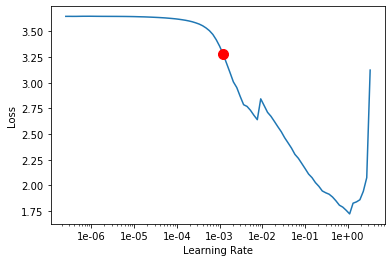

Optimum LR = 0.001202264434617413


In [5]:
# Find Learning Rate
lr = model.lr_find()
print(f"Optimum LR = {lr}")

The above method passes small batches of data to the model at a range of learning rates while records the losses for the respective learning rate after trainig. The result is this graph where loss has been plotted at y-axis with the respective learning rate at x-axis. Looking at the above graph we can see that the loss continously decreases after 1e-06 or .000001 and continous falling untill  bumping back at 1e-02, we can now pick any value near to the center of this steepest decline. Now we will pick 1e-03 or .001 so that can be set the highest learning rate and lowest learning rate a tenth of it in the next step.

### Fit the model

We would fit the model for 30 `epochs`. One epoch mean the model will see the complete training set once and so on.

In [7]:
# Training
model.fit(10, lr=0.001)

KeyboardInterrupt: 

The full training data was split into training set and validation set at the [Prepare Data step](#Prepare-Data), by default the validation set is .2 or 20% of the full training data and the remaining 80% goes in the training set. Here we can see loss on both training and validatiaon set, it helps us to be aware about how well our model generalizes on data which it has never seen and prevent overfitting of the model. Also as we can see our model here is able to classify pixels to building or non building with an accuracy of 96%.

### Save the model

We would now save the model which we just trained as a 'Deep Learning Package' or '.dlpk' format. Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform. `MultiTaskRoadExtractor` models can be deployed by the tool 'Classify Pixels Using Deep Learning' available in <a href="https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/classify-pixels-using-deep-learning.htm">ArcGIS Pro</a> as well as <a href="https://developers.arcgis.com/rest/services-reference/classify-pixels-using-deep-learning-.htm">ArcGIS Enterprise</a>. For this sample we will using this model in ArcGIS Pro to extract building footprints.

We will use the `save()` method to save the model and by default it will be saved to a folder 'models' inside our training data folder itself.

In [8]:
# Save model to file
model.save('mtl_road_extractor_30epochs')

Computing model metrics...


UnboundLocalError: local variable 'model_iou' referenced before assignment

### Load an Intermediate model to train it further

If we need to further train an already saved model we can load it again using the code below and go back to [Train the model step](#Train-the-Model) and further train it.

In [2]:
# Load Model from previous saved files 
# model.load('30e')


### Preview Results

The code below will pick a few random samples and show us ground truth and respective model predictions side by side. This allows us to preview the results of your model in the notebook itself, once satisfied we can save the model and use it further in our workflow.

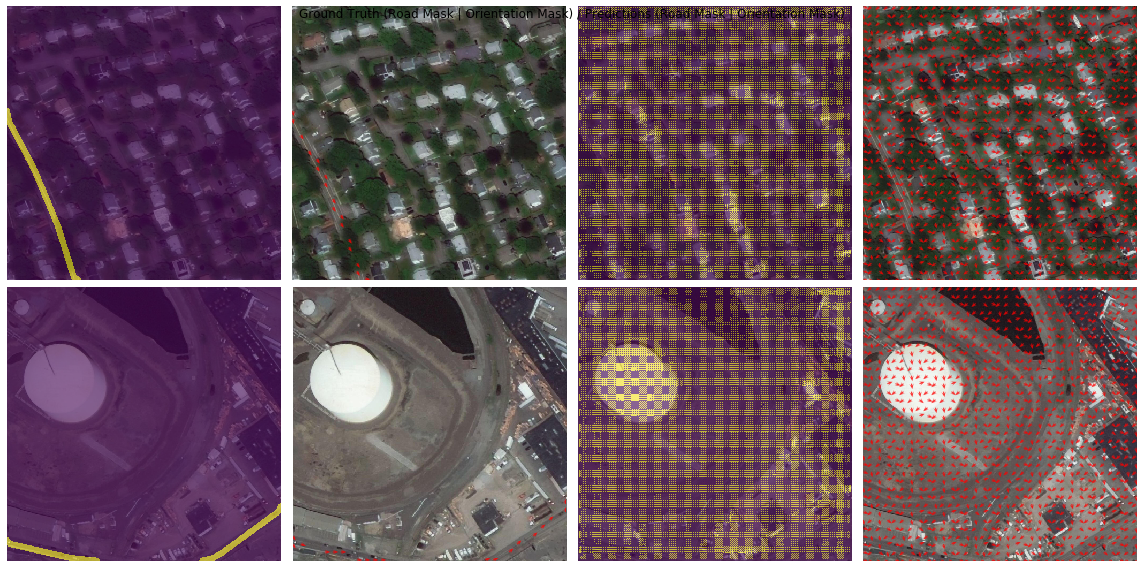

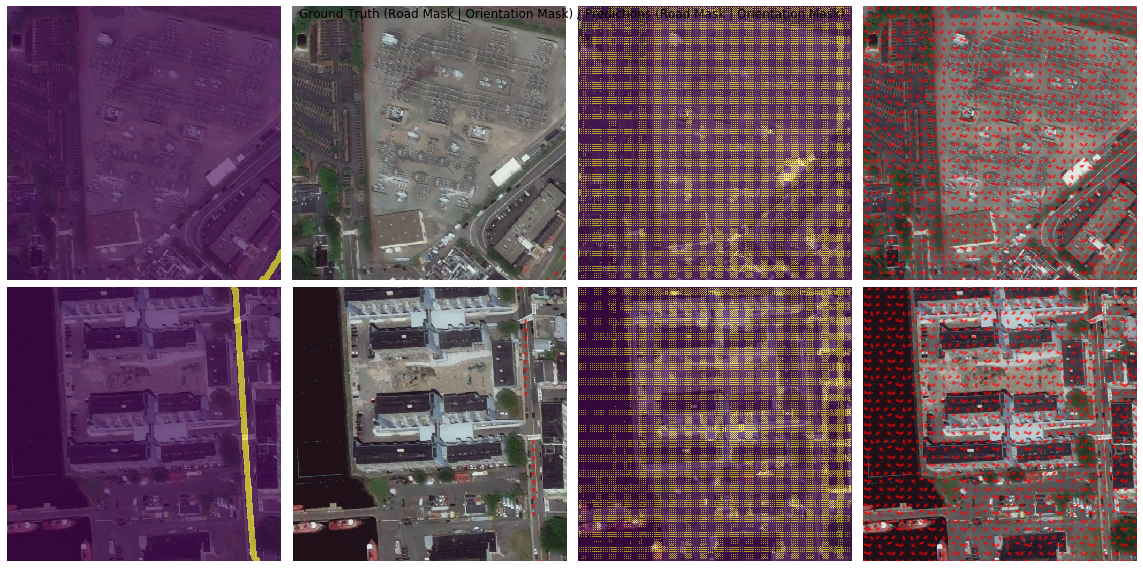

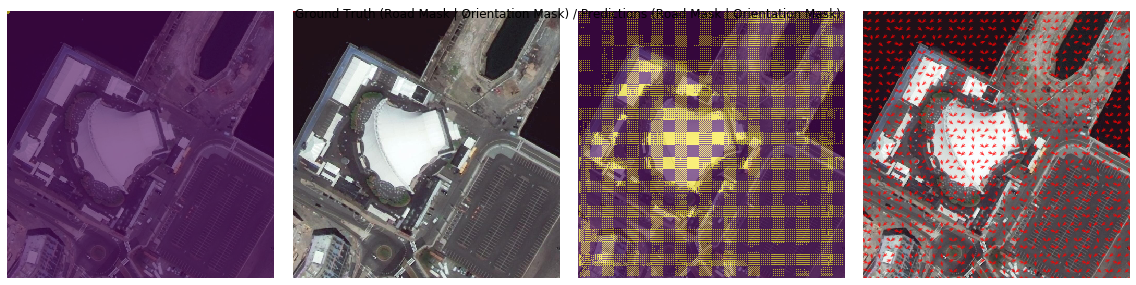

In [6]:
# Preview Results
model.show_results()

## Deploy Model and Extract Footprints

The deep learning package saved in previous step can be used to extract classfied raster using 'Classify Pixels Using Deep Learning' tool.
Further the classfied raster is regularised and finally converted to a vector Polygon layer. The regularisation step uses advanced ArcGIS geoprocessing tools to remove unwanted artifacts in the output. 

### Generate a 'Classified Raster' using 'Classify Pixels Using Deep Learning' tool

In this step we will generate a classfied raster using 'Classify Pixels Using Deep Learning' tool available in both <a href="https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/classify-pixels-using-deep-learning.htm">ArcGIS Pro</a> and <a href="https://developers.arcgis.com/rest/services-reference/classify-pixels-using-deep-learning-.htm">ArcGIS Enterprise</a>.

- Input Raster: The raster layer from which we want to extract building footprints from.
- Model Definition: It will be located inside the saved model in 'models' folder in '.emd' format.
- padding: The 'Input Raster' is tiled and the deep learning model classifies each individual tile separately before producing the final 'Output Classified Raster'. This may lead to unwanted artifacts along the edges of each tile as the model has little context to predict accuratly. Padding as the name suggests allows us to supply some extra information along the tile edges, this helps the model to predict better. 
- Cell Size: Should be close to at which we trained the model, we specified that at the [Export training data step]("#Export-training-data") .
- Processor Type: This allows to control wether the system's 'GPU' or 'CPU' would be used in to classify pixels, by 'default GPU' will be used if available.
- Parallel Processing Factor: This allows us to scale this tool, this tool can be scaled on both 'CPU' and 'GPU'. It specifies that the opration would be spread across how many 'cpu cores' in case of cpu based operation or 'no of GPU's' incase of GPU based operation.
<div>
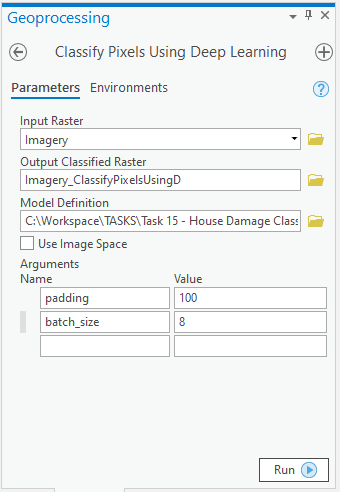
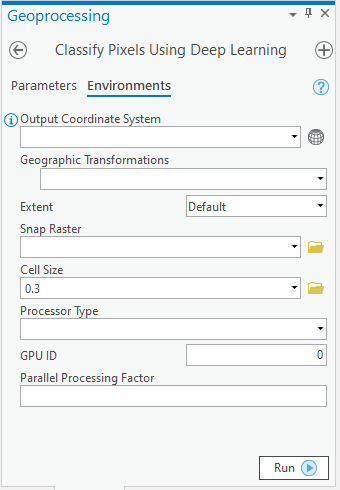
</div>


## Limitations

This type of model is able to predict the roads occluded by small and medium length shadows, however when roads have larger occlusions from clouds/shadows then it is unable to create connected road network.